In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
main_df = pd.read_csv('diabetes.csv')

print(main_df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [5]:
##### Split between X and y #####

X_main=main_df.drop('Outcome',axis=1)
y_main=main_df['Outcome']

##### Split between train and main #####

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_main,y_main,
                                               test_size=0.33,random_state=1)

print('train size is %i'%y_train.shape[0])
print('test size is %i'%y_test.shape[0])

train size is 514
test size is 254


In [7]:
names=main_df.columns.values

##### Preliminary Analysis #####
         
zeros=[]
for i in range(len(names)):
    zeros.append(np.count_nonzero(main_df[names[i]]==0))
CountZero=pd.DataFrame({'names':names,'zeros':zeros})
print(CountZero)


                      names  zeros
0               Pregnancies    111
1                   Glucose      5
2             BloodPressure     35
3             SkinThickness    227
4                   Insulin    374
5                       BMI     11
6  DiabetesPedigreeFunction      0
7                       Age      0
8                   Outcome    500


In [8]:
##### Transform the O in -1, except for pregnancies #####

for j in range(1,len(names)-1):
    for i in range(len(main_df)):
        if main_df.iloc[i,j]==0:
            main_df.iloc[i,j]=-1

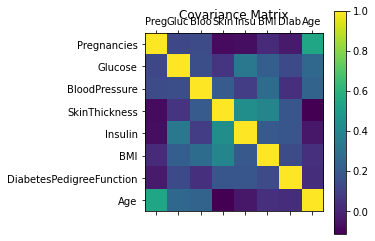

In [9]:
##### Covariance matrix #####

corr=X_main.corr()
plt.matshow(corr)

y_label=X_main.columns.values
y_pos=np.arange(len(y_label))
x_label=y_label.copy()
for i in range(len(x_label)):
    x_label[i]=y_label[i][:4]
x_pos=np.arange(len(x_label))
plt.xticks(x_pos,x_label)
plt.yticks(y_pos,y_label)
plt.colorbar()
plt.title('Covariance Matrix')

plt.show()

The features are not much correlated, so we don't need to use a matrix dimension reducer like PCA.

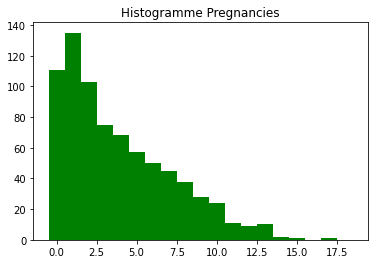

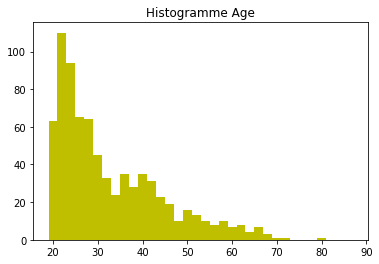

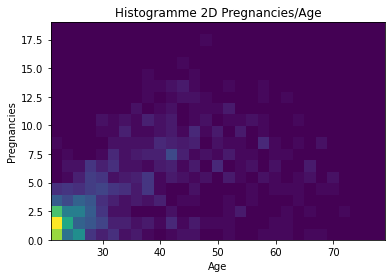

In [10]:
##### Histogrammes ###### 

plt.figure(2)
plt.hist(main_df['Pregnancies'],color='g',bins=range(0,20),align='left')
plt.title('Histogramme Pregnancies')
plt.show()

plt.figure(3)
plt.hist(main_df['Age'],color='y',bins=range(20,90,2),align='left')
plt.title('Histogramme Age')
plt.show()

plt.figure(4)
plt.hist2d(main_df['Age'],main_df['Pregnancies'],bins=[range(21,80,2),range(0,20)])
plt.xlabel('Age')
plt.ylabel('Pregnancies')
plt.title('Histogramme 2D Pregnancies/Age')
plt.show()


In [12]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [14]:
## classifier
svm=SVC(probability=True)
reglog=LogisticRegression()

## preprocess
scale_pipe=StandardScaler()
poly=PolynomialFeatures(degree=2)
imput=SimpleImputer(missing_values=-1,strategy='mean')

## grid parameters
param_svm=dict(clf__C=[0.001,0.1,1,10],clf__kernel=['rbf','linear','sigmoid'])
param_reglog=dict(clf__C=[0.001,0.1,1,10])

## declaration
clf_name=['SVM','RegLog']
clf=[svm,reglog]
param_grid=[param_svm,param_reglog]

auc_all=[]
fpr_all=[]
tpr_all=[]

train_size_all=[]
train_score_all=[]
cv_score_all=[]

In [15]:
for i in [0,1]:

### pipeline ###

    pipe=Pipeline([('imput',imput),('poly',poly),
                   ('scale',scale_pipe),('clf',clf[i])])

### grid ###

    grid=GridSearchCV(pipe,param_grid=param_grid[i],cv=4,scoring='accuracy')
    g=grid.fit(X_train,y_train)

### prediction ###

## resultats CV
    result=grid.cv_results_

## best parameters 
    bp=grid.best_params_
    print('Best parameters for %s:'%clf_name[i])
    print(bp)

## best estimator 
    be=grid.best_estimator_


### Results ### 

## prediction score
    
    predict=be.predict(X_test)

## scores

    report=metrics.classification_report(y_test,predict)

    conf_mat=metrics.confusion_matrix(y_test,predict)

    print('Reporting for %s:'%clf_name[i])
    print(report)

    print('Confusion matrix for %s:'%clf_name[i])
    print(conf_mat)

### learning curve ###

    from sklearn.model_selection import learning_curve
    from sklearn.model_selection import ShuffleSplit

    cv=ShuffleSplit(n_splits=10,test_size=0.2,train_size=None,random_state=1)


    train_size,train_score,cv_score=learning_curve(be,X_main,
                                                 y_main,
                                                 cv=cv,scoring='accuracy')
    
    train_size_all.append(train_size)
    train_score_all.append(train_score)
    cv_score_all.append(cv_score)

### ROC curve ###

    clf_proba=be.predict_proba(X_test)

    fpr,tpr,thresolds=roc_curve(y_test,clf_proba[:,1])
    
    auc=roc_auc_score(y_test,clf_proba[:,1])
    
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    auc_all.append(auc)

Best parameters for SVM:
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Reporting for SVM:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       162
           1       0.83      0.53      0.65        92

    accuracy                           0.79       254
   macro avg       0.80      0.74      0.75       254
weighted avg       0.80      0.79      0.78       254

Confusion matrix for SVM:
[[152  10]
 [ 43  49]]
/Users/jaku/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jaku/op

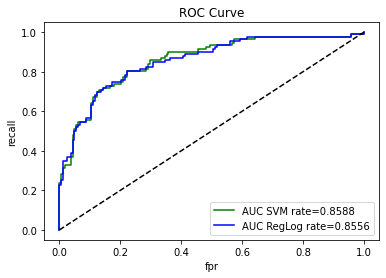

In [16]:
plt.plot(fpr_all[0],tpr_all[0],'g',label='AUC SVM rate=%0.4f'%auc_all[0])
plt.plot(fpr_all[1],tpr_all[1],'b',label='AUC RegLog rate=%0.4f'%auc_all[1])

plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('fpr')
plt.ylabel('recall')
plt.legend(loc='lower right')

plt.show()

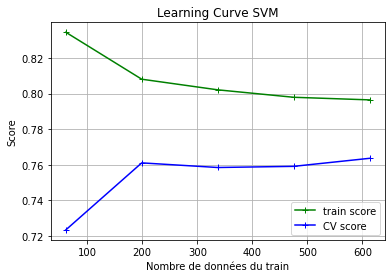

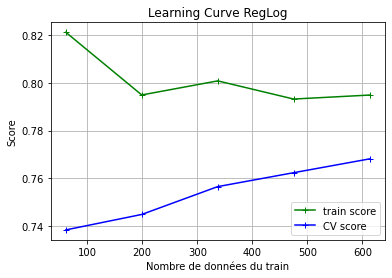

In [17]:
## learning curve

# train_score all have 3 dimensions: 1. algorithm: 2 values
#                                   2. train size: 5 valeurs
#                                   3. score: n values, n=n_split
train_score_mean=np.mean(train_score_all,axis=2) 
cv_score_mean=np.mean(cv_score_all,axis=2)
    

plt.plot(train_size,train_score_mean[0],marker='+',color='g',label='train score')
plt.plot(train_size,cv_score_mean[0],marker='+',color='b',label='CV score')
plt.title('Learning Curve SVM')
plt.xlabel('Nombre de données du train')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

plt.plot(train_size,train_score_mean[1],marker='+',color='g',label='train score')
plt.plot(train_size,cv_score_mean[1],marker='+',color='b',label='CV score')
plt.title('Learning Curve RegLog')
plt.xlabel('Nombre de données du train')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()